In [1]:
import numpy as np
#from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random
import copy
from IPython.display import HTML

# Pendulum On a Rail
We now introduce a moving rail to one end of the pendulum. To find a differential equation for this, the Lagrangian method is useful. The Lagrangian, kinetic energy minus potential energy, is thus:

$\mathcal{L} = \frac{1}{2}m(\dot{x}^2+\dot{y}^2)-mgy$.

To introduce the motion of the pivot, we write $x$ and $y$ in a different way, so that the position of the pivot is taken into account:

$x = L \sin(\theta)+x_p, \quad y = -L\cos(\theta)$,

$\dot{x} = L \dot{\theta} \cos(\theta)+\dot{x_p}, \quad \dot{y} = L \dot{\theta} \sin(\theta)$.

Thus:

$\mathcal{L} = \frac{1}{2}m(\dot{\theta}^2 L^2 + \dot{x_p}^2 + 2L\dot{\theta}\dot{x_p}\cos{\theta})+mgL\sin(\theta)$

Solving the Euler-Lagrange equation for $\theta$ gives us:

$\ddot{\theta} = -\frac{1}{L}(\cos(\theta)\ddot{x_p}+g\sin{\theta})$.

To test the system of equations we will set the pivots acceleration to be sinusoidal.

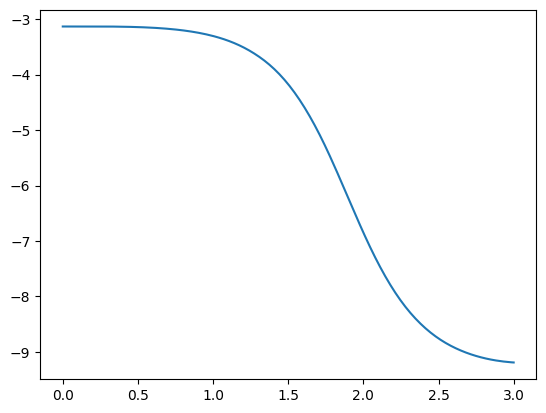

In [ ]:
# Ensure ffmpeg is installed
plt.rcParams['animation.ffmpeg_path'] = 'ffmpeg'  # Adjust the path if necessary

# Define parameters
L = 1.0  # Radius or a characteristic length
g = 9.81  # Acceleration due to gravity, in m/s^2

# Create function for pendulum motion
def x_p(t,theta=(0)):
      return np.sin(t)

def x_p_dot(t):
    return (x_p(t+dt) - x_p(t))/(dt)

def x_p_double_dot(t):
    return (x_p_dot(t+dt) - x_p_dot(t))/(dt)

# Define the system of first-order ODEs
def odes(t, y):
    theta, theta_dot = y  # Unpack the state variables
    theta_double_dot = - (1 / L) * (g * np.sin(theta) + x_p_double_dot(t) * np.cos(theta))  # Calculate the derivatives
    return [theta_dot, theta_double_dot]

# Initial conditions
theta_0 = -np.pi + 0.01 # Initial condition for theta
theta_dot_0 = 0  # Initial condition for theta_dot
y0 = [theta_0, theta_dot_0]  # Initial condition vector

# Time span for the solution
t_span = (0, 3)  # From t=0 to t=10 seconds
fps = 60
t_eval = np.linspace(*t_span, 3*fps)  # Time points to evaluate the solution
dt = t_eval[1] - t_eval[0]  # Time step

# Solve the differential equation
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval)

# Extract the solution
theta = solution.y[0]
t = solution.t
x_p_solution = x_p(t_eval)

plt.plot(t_eval, theta)

# Animating the pendulum

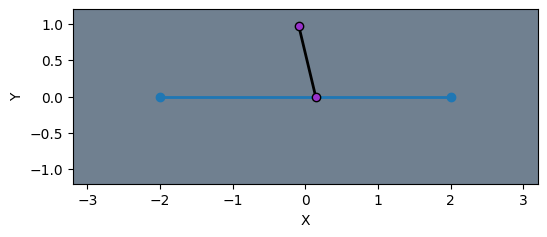

In [ ]:
# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.set_facecolor('slategrey')
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Initialize the pendulum line
track, = ax.plot([], [], 'o-', lw=2)
track.set_data([-2,2],[0,0])
line, = ax.plot([], [], 'o-', lw=2)


# Animation initialization function
def init():
    line.set_data([], [])
    line.set_color('black')
    line.set_markerfacecolor('darkorchid')
    line.set_markeredgecolor('black')
    return line,

# Animation update function
def update(frame):
    x = x_p_solution[frame] + np.sin(theta[frame])
    y = -np.cos(theta[frame])
    line.set_data([x_p_solution[frame], x], [0, y])
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(t_eval), init_func=init, blit=True, interval=dt*1000)

HTML(ani.to_jshtml())

# Neural Network Set-up
We are now to set up the neural network class.

### Topological Sort
This will become very useful when evaluating the output of a network, given an input. A summary of what the algorithm does can be read a this [site](https://www.interviewcake.com/concept/java/topological-sort).

In [90]:
# Creating the mechanism of neural network
# Position: placement along rail
# Theta: angle between pivot and weight
# Angular velocity: angular velocity of weight
#position, theta, angular_velocity = [0,0,0]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

class neural_network():
    def __init__(self, number_of_input_nodes, number_of_output_nodes):
        self.input_size = number_of_input_nodes
        self.output_size = number_of_output_nodes
        self.hidden_nodes = []
        self.num_nodes = number_of_input_nodes + number_of_output_nodes
        self.connections = {}
        self.weights = {}      # {(from_node, to_node): weight}
        self.biases = {}       # {node: bias}
        self.activation_functions = {}

        # Initalise node connections
        for i in range(number_of_output_nodes):
            self.connections[f"output_{i}"] = [] # Output nodes have no following connections
        for i in range(number_of_input_nodes):
            self.connections[f"input_{i}"] = [node for node in list(self.connections.keys()) if 'output' in node] # All input nodes connect to all output nodes

        # Initialise node weights for each connections
        for from_node in self.connections.keys():
            for to_node in self.connections[from_node]:
                self.weights[(from_node, to_node)] = self._random_weight()

        # Initialise random bisaes for each node
        for node in self.connections.keys():
            self.biases[node] = self._random_weight()

        # Initialise activation functions
        self.activation_functions["output"] = [np.tanh]
        self.activation_functions["hidden"] = [np.tanh]

    def _random_weight(self):
           return np.random.uniform(-1,1)

    def create_node(self):
        # Add a new node to the neural network

        # Find a random edge on the network
        # First node can not be an output
        random_node_1 = np.random.choice([node for node in list(self.connections.keys()) if 'output' not in node])
        # Second node is collected from the connections of the first random node
        random_node_2 = np.random.choice(list(self.connections[random_node_1]))

        # Break this edge
        self.connections[random_node_1] = [node for node in list(self.connections[random_node_1]) if random_node_2 not in node]
        del self.weights[(random_node_1, random_node_2)]

        # Create the hidden node to be added
        hidden_node = f"hidden_{len(self.hidden_nodes)}"
        self.hidden_nodes.append(hidden_node)
        self.biases[hidden_node] = self._random_weight()
        self.connections[hidden_node] = [random_node_2] # Link hidden node to the second node of the broken edge
        self.connections[random_node_1].append(hidden_node) # Add the hidden node to the outputs of first node of broken edge

        # Potentially add more outputs of this hidden node
        no_additional_outputs = np.random.randint(0,2)
        # Allowed outputs can not be inputs, the hidden node itself, or either of the random nodes
        allowed_outputs = [node for node in list(self.connections.keys()) if (
                           'input' not in node
                           and hidden_node != node
                           and random_node_1 != node
                           and random_node_2 != node
                           )]
        additional_random_outputs = []
        # Choose nodes from selection of allowed outputs
        if allowed_outputs != []:
            additional_random_outputs = np.random.choice(allowed_outputs, size=no_additional_outputs, replace=False)
            for i in range(len(additional_random_outputs)):
                # Append to the connections dict
                self.connections[hidden_node].append(additional_random_outputs[i])
                self.weights[(hidden_node, additional_random_outputs[i])] = self._random_weight() # Assign random weight to this connection

        # Potentially add more inputs of this hidden node
        no_additional_inputs = np.random.randint(0,2)
        # Allowed outputs can not be inputs, the hidden node itself, or either of the random nodes
        allowed_inputs = [node for node in list(self.connections.keys()) if (
                           'output' not in node
                           and hidden_node != node
                           and random_node_1 != node
                           and random_node_2 != node
                           and node not in additional_random_outputs
                           )]
        # Choose nodes from selection of allowed outputs
        additional_random_inputs = np.random.choice(allowed_inputs, size=no_additional_outputs, replace=False)
        for i in range(len(additional_random_inputs)):
            # Append to the connections dict
            self.connections[additional_random_inputs[i]].append(hidden_node)
            self.weights[(additional_random_inputs[i], hidden_node)] = self._random_weight() # Assign random weight to this connection

        # Initialise new weights
        self.weights[(hidden_node, random_node_2)] = self._random_weight()
        self.weights[(random_node_1, hidden_node)] = self._random_weight()

    def create_connection(self):
        random_node_1 = np.random.choice([node for node in list(self.connections.keys()) if 'output' not in node])
        excluded_nodes = np.random.choice(list(self.connections[random_node_1]))
        random_node_2 = np.random.choice([node for node in list(self.connections.keys()) if node not in excluded_nodes])
        self.connections[random_node_1].append(random_node_2)
        self.weights[(random_node_1, random_node_2)] = self._random_weight()

    def print_network(self):
        for node, connections in self.connections.items():
            if connections != []:
                for c in connections:
                    weight = self.weights[(node, c)]
                    print(f"{node} -> {c} with weight {weight}")
            else:
                print(f"{node} -> none")

    def topological_sort(self):
        visited = set()
        stack = []

        def dfs(node):
            if node not in visited:
                visited.add(node)
                # Recursively visit all adjacent nodes
                for neighbor in self.connections[node]:
                    dfs(neighbor)
                # Push current node to stack after visiting all its neighbors
                stack.append(node)

        # Perform DFS from each node
        for node in self.connections:
            if node not in visited:
                dfs(node)

        # Return nodes in reverse order (since stack gives us the reverse topological sort)
        return stack[::-1]

    def randomise_parameter(self):
        w = list(self.weights.keys())
        b = list(self.biases.keys())
        all_parameters = w + b
        random_parameter = random.choice(all_parameters) # Using random instead of np.random because np breaks when dealing with the tuples in weights
        if random_parameter in b:
            self.biases[random_parameter] = self._random_weight()
        else:
            self.weights[random_parameter] = self._random_weight()

    def has_cycle(self):
        visited = set()         # To keep track of visited nodes
        rec_stack = set()       # To keep track of nodes in the current recursion stack

        # Helper function for DFS
        def dfs(node):
            # If the node is already in the recursion stack, we found a cycle
            if node in rec_stack:
                return True

            # If the node is visited and not in the recursion stack, no need to visit again
            if node in visited:
                return False

            # Mark the node as visited and add to the recursion stack
            visited.add(node)
            rec_stack.add(node)

            # Visit all the adjacent nodes
            for neighbor in self.connections.get(node, []):
                if dfs(neighbor):
                    return True

            # Remove the node from the recursion stack before returning
            rec_stack.remove(node)
            return False

        # Check every node in the graph
        for node in self.connections.keys():
            if dfs(node):
                return True  # Cycle detected

        return False  # No cycles detected


    def evaluate(self, input):
        # Ensure the number of inputs matches the number of input nodes
        assert len(input) == self.input_size, "Input size mismatch."

        # Perform topological sort to determine evaluation order
        sorted_nodes = self.topological_sort()

        # Activation function lookup
        activation_hidden = self.activation_functions["hidden"][0]
        activation_output = self.activation_functions["output"][0]

        # Set input values
        values = {f"input_{i}": input[i] for i in range(self.input_size)}

        for node in sorted_nodes:
            if "input" in node:
                continue

            current_value = self.biases[node] + sum(
                self.weights[(from_node, node)] * values[from_node]
                for from_node in self.connections if node in self.connections[from_node]
            )

            # Apply activation functions
            if "hidden" in node:
                values[node] = activation_hidden(current_value)
            elif "output" in node:
                values[node] = activation_output(current_value)

        return values["output_0"]



In [89]:
network = neural_network(4,1)
network.create_node()
network.create_node()
breaker = 0

print(network.evaluate([0,0,0,0]))

CV0.10306519650238655
ACtiV0.1027018060200637
CV-0.9656180985943292
ACtiV-0.7467723701628801
0.5920670028735915


# Normalisation functions

In [3]:
# Normalising the input data
len_track = 4
len_lendulum = 1
def norm_position(position):
    return (2*position)/len_track

def norm_x_y(theta):
    x = np.sin(theta)
    y = -np.cos(theta)
    return [x,y]

def norm_omega(omega):
    return omega/10

# Create pendulum class

In [31]:
class Pendulum:
    def __init__(self, L, g):
        self.L = L  # Pendulum length
        self.g = g  # Acceleration due to gravity
        self.xd = []
        self.len_track = 4  # Length of track (centered on 0)

    def get_x_dot(self, x_p, theta, omega, network):
        x_norm, y_norm = norm_x_y(theta)
        x_p_norm = norm_position(x_p)
        omega_norm = norm_omega(omega)
        x_dot_new = network.evaluate([x_p_norm, x_norm, y_norm, omega_norm])
        # Check if pendulum position exceeds the rail boundaries
        if x_p < -self.len_track / 2:
            x_p = -self.len_track / 2
            x_dot_new = 0  # Stop velocity if it hits the boundary
        elif x_p > self.len_track / 2:
            x_p = self.len_track / 2
            x_dot_new = 0  # Stop velocity if it hits the boundary

        return x_dot_new

    def compute_x_p_double_dot(self, state, dt, network):
        x_p, x_p_dot, theta, omega = state
        x_dot = self.get_x_dot(x_p, theta, omega, network)
        x_p_double_dot = (x_dot - x_p_dot) / dt
        return x_p_double_dot

    def equations(self, t, state, network, dt):
        x_p, x_p_dot, theta, omega = state
        x_p_double_dot = self.compute_x_p_double_dot(state, dt, network)
        theta_double_dot = -(1 / self.L) * (self.g * np.sin(theta) + x_p_double_dot * np.cos(theta))
        return np.array([x_p_dot, x_p_double_dot, omega, theta_double_dot])

    def rk4_step(self, state, t, dt, network):
        k1 = dt * self.equations(t, state, network, dt)
        k2 = dt * self.equations(t + 0.5 * dt, state + 0.5 * k1, network, dt)
        k3 = dt * self.equations(t + 0.5 * dt, state + 0.5 * k2, network, dt)
        k4 = dt * self.equations(t + dt, state + k3, network, dt)
        return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    def integrate(self, theta_0, omega_0, x_p_0, x_p_dot_0, t_0, t_end, dt, network):
        num_steps = int((t_end - t_0) / dt) + 1
        self.theta = np.zeros(num_steps)
        self.omega = np.zeros(num_steps)
        self.x_p = np.zeros(num_steps)
        self.x_p_dot = np.zeros(num_steps)

        self.theta[0], self.omega[0] = theta_0, omega_0
        self.x_p[0], self.x_p_dot[0] = x_p_0, x_p_dot_0

        t = t_0
        idx = 1
        while idx < num_steps:
            state = np.array([self.x_p[idx - 1], self.x_p_dot[idx - 1], self.theta[idx - 1], self.omega[idx - 1]])
            new_state = self.rk4_step(state, t, dt, network)
            t += dt                
            self.x_p[idx], self.x_p_dot[idx], self.theta[idx], self.omega[idx] = new_state
            self.theta[idx] = ((self.theta[idx] + np.pi) % (2 * np.pi)) - np.pi

            idx += 1

        return [self.x_p, self.x_p_dot, self.theta, self.omega]

# Test of animation and integration

0.543623685836792


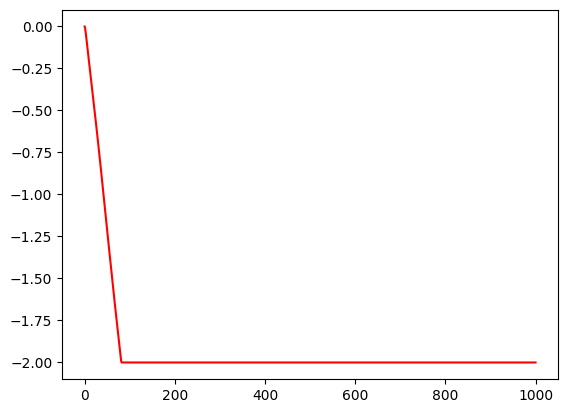

In [15]:
### Testing animation and integration
import time
pendulum = Pendulum(1, 9.81)

theta_0 = 0
omega_0 = 0
x_p_0 = 0
x_p_dot_0 = 0
t_0 = 0
t_end = 30
dt = 0.03

t1 = time.time()
network = neural_network(4,1)
network.create_node()
network.create_connection()

x_p, x_p_dot, theta, omega = pendulum.integrate(theta_0, omega_0, x_p_0, x_p_dot_0, t_0, t_end, dt, network)

print(time.time() - t1)

frames = len(theta)
plt.plot(np.array(x_p), color = "red")
#ani = animate_pendulum(x_p, theta, frames)
#print(ani)
#HTML(ani.to_jshtml())

# Animation Function

In [51]:
def animate_pendulum(x_p_solution, theta, frames, target_fps=30):
    '''
    To display:
    ani = animate_pendulum(x_p_solution, theta, frames)
    HTML(ani.to_jshtml())
    '''

    # Set up the figure and axis for the animation
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-3.2, 3.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_facecolor('slategrey')
    ax.grid(False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Initialize the pendulum line
    track, = ax.plot([], [], 'o-', lw=2)
    track.set_data([-2,2],[0,0])
    line, = ax.plot([], [], 'o-', lw=2)

    # Total number of time steps in the simulation
    total_steps = len(x_p_solution)
    # Total simulation time
    total_time = t_end
    # Target number of frames for 30 FPS animation
    target_frames = int(target_fps * total_time)

    # Downsample x_p_solution and theta to match the target number of frames
    frame_indices = np.linspace(0, total_steps - 1, target_frames).astype(int)
    x_p_solution_resampled = x_p_solution[frame_indices]
    theta_resampled = theta[frame_indices]

    # Animation initialization function
    def init():
        line.set_data([], [])
        line.set_color('black')
        line.set_markerfacecolor('darkorchid')
        line.set_markeredgecolor('black')
        return line,

    # Animation update function
    def update(frame):
        x = x_p_solution_resampled[frame] + np.sin(theta_resampled[frame])
        y = -np.cos(theta_resampled[frame])
        line.set_data([x_p_solution_resampled[frame], x], [0, y])
        return line,

    # Create the animation
    ani = animation.FuncAnimation(fig, update, target_frames, init_func=init, blit=True, interval=1000 / target_fps)
    return ani

# Reward function

In [101]:
def reward_func(state):
    x_p, x_p_dot, theta, omega = state
    reward = 0
    y_pos = norm_x_y(theta)[1]
    reward = sum([i**3 for i in y_pos if i > 0])
    
    #reward -= sum([i for i in abs(norm_omega(omega))])

    if (abs(norm_position(x_p)) > 1).any():
        reward -= 100
        
    return(reward)

In [34]:
def _winning_networks(network_zoo_rewards, top_fraction=0.3):
    '''
    Returns the top `top_fraction` fraction of networks and their associated probabilities.
    '''
    sorted_items = sorted(network_zoo_rewards.items(), key=lambda x: x[1], reverse=True)
    top_30_count = int(len(sorted_items) * top_fraction)
    top_keys = [key for key, _ in sorted_items[:top_30_count]]
    all_keys = [key for key, _ in sorted_items]

    min_value = sorted_items[-1][1]
    max_value = sorted_items[0][1]
    if max_value-min_value != 0:
        probability_array = [(network_zoo_rewards[key]-min_value)/(max_value-min_value) for key in all_keys]
    else:
        probability_array = np.ones(len(all_keys))
    normalisation_constant = sum(probability_array)**(-1)
    probability_array = [normalisation_constant * x for x in probability_array]

    return top_keys, all_keys, probability_array

def evolve_model(network_zoo, network_zoo_rewards, no_networks):
    '''
    Evolves the model by mutating the losing networks and adding back winning networks unchanged.
    '''
    # Define mutation proportions
    mutation_proportions = {
        'param_change': 0.4,
        'node_add': 0.1,
        'connection_add': 0.1,
        'remain_same': 0.1
    }

    # Compute number of networks for each mutation type
    counts = {key: int(no_networks * val) for key, val in mutation_proportions.items()}

    # Get the winning and losing networks along with probabilities
    winning_networks, all_networks_sorted, probability_array = _winning_networks(network_zoo_rewards)

    new_network_zoo = {}

    # Add back winning networks unchanged
    k = 0
    for network in winning_networks:
        new_network_zoo[f"network_{k}"] = network_zoo[network]
        k += 1

    # Mutate losing networks
    total_mutation = sum(counts.values()) - counts['remain_same']
    selected_networks = np.random.choice(all_networks_sorted, size=total_mutation, replace=True, p=probability_array)

    # Apply mutations (parameter change, node addition, and connection addition)
    for network in selected_networks[:counts['param_change']]:
        network_new = copy.deepcopy(network_zoo[network])
        network_new.randomise_parameter()
        new_network_zoo[f"network_{k}"] = network_new
        k += 1

    for network in selected_networks[counts['param_change']:counts['param_change'] + counts['node_add']]:
        breaker = 0
        while True or breaker < 3:
            network_new = copy.deepcopy(network_zoo[network])
            network_new.create_node()
            if not network_new.has_cycle():
                break
            breaker += 1
        new_network_zoo[f"network_{k}"] = network_new
        k += 1

    for network in selected_networks[counts['param_change'] + counts['node_add']:]:
        breaker = 0
        while True or breaker < 3:
            network_new = copy.deepcopy(network_zoo[network])
            network_new.create_connection()
            if not network_new.has_cycle():
                break
            breaker += 1
        new_network_zoo[f"network_{k}"] = network_new
        k += 1

    # Networks that remain the same
    unchanged_networks = np.random.choice(all_networks_sorted, size=counts['remain_same'], replace=True, p=probability_array)
    for network in unchanged_networks:
        new_network_zoo[f"network_{k}"] = network_zoo[network]
        k += 1

    return new_network_zoo

def try_add_node(network):
    ''' Try adding a node to the network, ensuring no cycle is created. '''
    for _ in range(3):
        network.create_node()
        if not network.has_cycle():
            break
    return network

def try_add_connection(network):
    ''' Try adding a connection to the network, ensuring no cycle is created. '''
    for _ in range(3):
        network.create_connection()
        if not network.has_cycle():
            break
    return network

def run_pendulum(network_zoo):
    '''
    Run pendulum simulations for all networks and return the rewards.
    '''
    network_zoo_rewards = {}
    for i in range(no_networks):
        state = pendulum.integrate(theta_0, omega_0, x_p_0, x_p_dot_0, t_0, t_end, dt, network_zoo[f"network_{i}"])
        network_zoo_rewards[f"network_{i}"] = reward_func(state)

    return network_zoo_rewards


In [102]:
### Setup pendulum
# Pendulum parameters
L = 1.0  # Length of the pendulum in meters
g = 9.81  # Gravitational acceleration in m/s^2

# Initial conditions: theta_0 (initial angle), omega_0 (initial angular velocity), x_p_0 (initial pivot position)
theta_0 = 0 # Pendulum at equilibrium
omega_0 = 0.0  # Initially at rest
x_p_0 = 0.0  # Initial position of the pivot
x_p_dot_0 = 0.0 # Pivot at rest
t_0 = 0.0  # Initial time
t_end = 20.0  # End time for simulation
dt = 0.1 # Time step for integration

# Create a Pendulum object
pendulum = Pendulum(L, g)

In [103]:
### Create network zoo
no_networks = 100
network_zoo = {}
network_zoo_rewards = {}
high_score = [0]

# Setup
for i in range(no_networks):
    network_zoo[f"network_{i}"] = neural_network(4,1)

    # Integrate the pendulum's motion
    state = pendulum.integrate(theta_0, omega_0, x_p_0, x_p_dot_0, t_0, t_end, dt, network_zoo[f"network_{i}"])
    network_zoo_rewards[f"network_{i}"] = reward_func(state)

In [104]:
# Iterate to train
no_generations = 100
for i in range(no_generations):
    network_zoo_rewards = run_pendulum(network_zoo)
    network_zoo = evolve_model(network_zoo, network_zoo_rewards, no_networks)

    # Statistics
    winners, all_keys_sorted, prob = _winning_networks(network_zoo_rewards)
    high_score.append(network_zoo_rewards[winners[0]])
    mean_score = np.mean([network_zoo_rewards[i] for i in winners])
    print(f"Generation: {i+1}/{no_generations}      Highscore: {high_score[-1]}      Mean: {mean_score}")

print("--- Running Final Evaluation ---")
network_zoo_rewards = run_pendulum(network_zoo)
high_score.append(network_zoo_rewards["network_0"])
print(f"BEST SCORE: {high_score[-1]}")

plt.plot(high_score)
plt.plot(np.ones(len(high_score)) * (t_end / dt))
plt.xlabel("Generation Winner")

Generation: 1/100      Highscore: 30.551190571382133      Mean: -0.589340559851145
Generation: 2/100      Highscore: 30.551190571382133      Mean: 9.179235827558578
Generation: 3/100      Highscore: 30.551190571382133      Mean: 14.608083736993109
Generation: 4/100      Highscore: 30.551190571382133      Mean: 19.3900785246831
Generation: 5/100      Highscore: 33.11978911110961      Mean: 24.90938477418723
Generation: 6/100      Highscore: 33.11978911110961      Mean: 27.134703410411138
Generation: 7/100      Highscore: 33.11978911110961      Mean: 28.75241298369173
Generation: 8/100      Highscore: 33.11978911110961      Mean: 29.81150134418108
Generation: 9/100      Highscore: 33.11978911110961      Mean: 30.546865586066975
Generation: 10/100      Highscore: 33.11978911110961      Mean: 30.925196875403397
Generation: 11/100      Highscore: 33.11978911110961      Mean: 31.068655430638056
Generation: 12/100      Highscore: 35.098881575860034      Mean: 31.63596864785009
Generation: 13/

KeyboardInterrupt: 

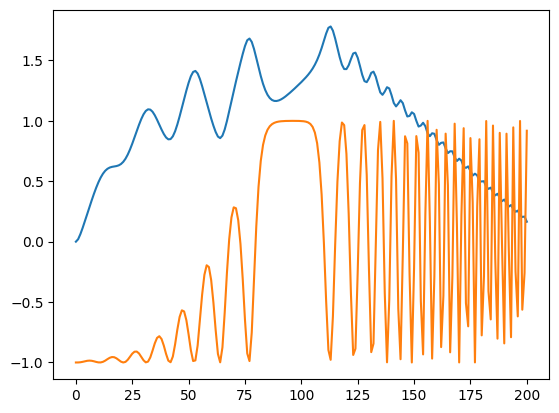

In [106]:
winning_network = network_zoo["network_0"]
x_p, x_p_dot, theta, omega = pendulum.integrate(theta_0, omega_0, x_p_0, x_p_dot_0, t_0, t_end, dt, winning_network)
plt.plot(x_p)
plt.plot(norm_x_y(theta)[1])
#frames = len(theta)
#ani = animate_pendulum(x_p, theta, frames, target_fps=15)
#HTML(ani.to_jshtml())

In [118]:
import gym
env = gym.make("CartPole-v1")
import gym
env = gym.make("LunarLander-v2", render_mode="human")
env.action_space.seed(42)

observation, info = env.reset(seed=42)

for _ in range(1000):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())

    if terminated or truncated:
        observation, info = env.reset()

env.close

DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`